# Apple stock price prediction

Predicting the next day's stock price based on historical prices using a cleaned-up version of Apple's historical stock data sourced from the [Nasdaq website](https://www.nasdaq.com/market-activity/stocks/aapl/historical).

In [ ]:
raise SystemExit("Stop right there!");

<a id="importing"></a>
## Importing libraries and packages

In [1]:
# System
import os

# Mathematical operations and data manipulation
import numpy as np
import pandas as pd
import math

# Modelling
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from tensorflow.keras import layers

# Plotting
import matplotlib.pyplot as plt
from IPython.display import display, HTML

%matplotlib inline
display(HTML("<style>.container {width:80% !important;}</style>"))

print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

Tensorflow version: 2.4.1
Keras version: 2.4.3


In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

<a id="set-paths"></a>
## Set paths

In [3]:
# Path to datasets directory
data_path = "./datasets"
# Path to assets directory (for saving results to)
assets_path = "./assets"

<a id="loading-data"></a>
## Loading dataset

In [4]:
dataset = pd.read_csv(f"{data_path}/AAPL.csv")

In [5]:
dataset.head()

Date   Close    Open     High     Low   Volume
0  1/17/2020  138.31  136.54  138.330  136.16  5623336
1  1/16/2020  137.98  137.32  138.190  137.01  4320911
2  1/15/2020  136.62  136.00  138.055  135.71  4045952
3  1/14/2020  135.82  136.28  137.139  135.55  3683458
4  1/13/2020  136.60  135.48  136.640  135.07  3531572

In [6]:
dataset.tail()

Date   Close    Open     High     Low    Volume
2509  1/29/2010  122.39  124.32  125.000  121.90  11571890
2510  1/28/2010  123.75  127.03  127.040  123.05   9616132
2511  1/27/2010  126.33  125.82  126.960  125.04   8719147
2512  1/26/2010  125.75  125.92  127.750  125.41   7135190
2513  1/25/2010  126.12  126.33  126.895  125.71   5738455

<a id="exploring-data"></a>
## Exploring dataset

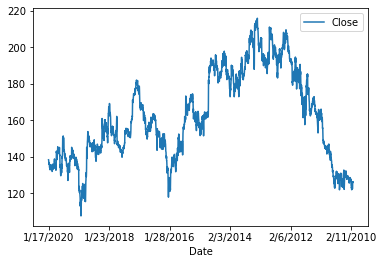

In [7]:
dataset.plot("Date", "Close")
plt.show()

In [8]:
# Reversing the data for convenience of plotting and handling
dataset = dataset.sort_index(ascending=False)

In [9]:
# Extracting values for ‘Close’ from the dataframe as a numpy array.
ts_data = dataset.Close.values.reshape(-1, 1)

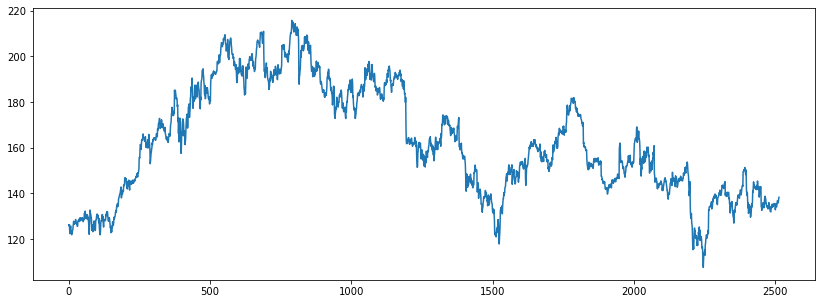

In [10]:
plt.figure(figsize=(14, 5))
plt.plot(ts_data)
plt.show()

<a id="prepare"></a>
## Preparing the data

In [11]:
# Preparing the data for stock price prediction
train_recs = int(len(ts_data) * 0.75)

train_data = ts_data[:train_recs]
test_data = ts_data[train_recs:]

len(train_data), len(test_data)

(1885, 629)

In [12]:
# Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [13]:
def get_lookback(inp, look_back):
    y = pd.DataFrame(inp)
    dataX = [y.shift(i) for i in range(1, look_back + 1)]
    dataX = pd.concat(dataX, axis=1)
    dataX.fillna(0, inplace=True)
    return dataX.values, y.values

In [14]:
look_back = 10
trainX, trainY = get_lookback(train_scaled, look_back=look_back)
testX, testY = get_lookback(test_scaled, look_back=look_back)

In [15]:
trainX.shape, testX.shape

((1885, 10), (629, 10))

<a id="base"></a>
## Base RNN model

In [16]:
# Training base model (requires numpy=1.19,
# see https://github.com/tensorflow/models/issues/9706)
model = tf.keras.Sequential(
    [
        layers.Reshape((look_back, 1), input_shape=(look_back,)),
        layers.SimpleRNN(32, input_shape=(look_back, 1)),
        layers.Dense(1),
        layers.Activation("linear"),
    ]
)

In [17]:
model.compile(loss="mean_squared_error", optimizer="adam")

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 10, 1)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1088      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(
    trainX, trainY, epochs=3, batch_size=1, verbose=2, validation_split=0.1
)

Epoch 1/3
1696/1696 - 13s - loss: 0.0084 - val_loss: 0.0010
Epoch 2/3
1696/1696 - 14s - loss: 0.0011 - val_loss: 8.3796e-04
Epoch 3/3
1696/1696 - 15s - loss: 9.4386e-04 - val_loss: 3.3792e-04


In [20]:
def calculate_performance(model_obj):

    score_train = model_obj.evaluate(trainX, trainY, verbose=0)
    print("Train RMSE: %.2f RMSE" % (math.sqrt(score_train)))

    score_test = model_obj.evaluate(testX, testY, verbose=0)
    print("Test RMSE: %.2f RMSE" % (math.sqrt(score_test)))


calculate_performance(model)

Train RMSE: 0.03 RMSE
Test RMSE: 0.03 RMSE


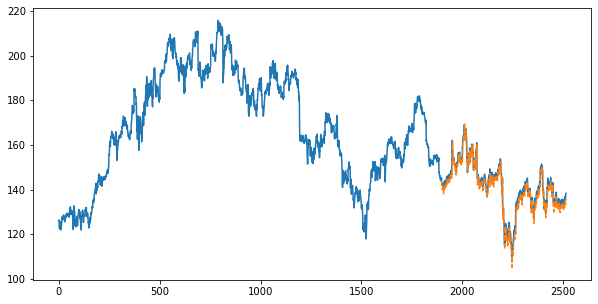

In [21]:
def plot_prediction(model_obj):
    testPredict = scaler.inverse_transform(model_obj.predict(testX))

    pred_test_plot = ts_data.copy()
    pred_test_plot[: train_recs + look_back, :] = np.nan
    pred_test_plot[train_recs + look_back :, :] = testPredict[look_back:]

    plt.plot(ts_data)
    plt.plot(pred_test_plot, "--")


plt.figure(figsize=(10, 5))
plot_prediction(model)

<a id="one"></a>
## 1D convolution-based model

In [22]:
# Training 1D convolution-based model
model_conv = tf.keras.Sequential(
    [
        layers.Reshape((look_back, 1), input_shape=(look_back,)),
        layers.Conv1D(5, 5, activation="relu"),
        layers.MaxPooling1D(5),
        layers.Flatten(),
        layers.Dense(1),
        layers.Activation("linear"),
    ]
)

In [23]:
model_conv.compile(loss="mean_squared_error", optimizer="adam")

In [24]:
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 5)              30        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 5)              0         
_________________________________________________________________
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 36
Trainable params: 36
Non-trainable params: 0
__________________________________________________________

In [25]:
model_conv.fit(
    trainX, trainY, epochs=5, batch_size=1, verbose=2, validation_split=0.1
)

Epoch 1/5
1696/1696 - 4s - loss: 0.0128 - val_loss: 0.0011
Epoch 2/5
1696/1696 - 4s - loss: 0.0017 - val_loss: 9.8598e-04
Epoch 3/5
1696/1696 - 4s - loss: 0.0016 - val_loss: 7.6665e-04
Epoch 4/5
1696/1696 - 5s - loss: 0.0015 - val_loss: 9.4015e-04
Epoch 5/5
1696/1696 - 4s - loss: 0.0014 - val_loss: 0.0011


In [26]:
calculate_performance(model_conv)

Train RMSE: 0.04 RMSE
Test RMSE: 0.04 RMSE


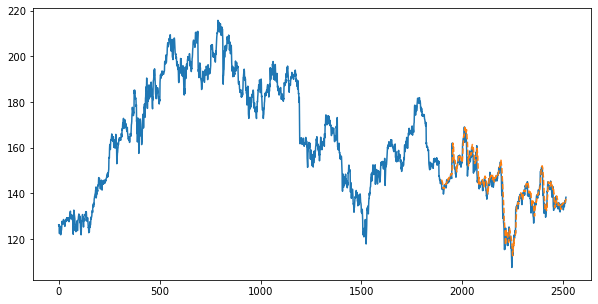

In [27]:
plt.figure(figsize=(10, 5))
plot_prediction(model_conv)

<a id="hybrid"></a>
## Hybrid model

In [28]:
# Training a hybrid (1D conv + RNN) model
model_hybrid = tf.keras.Sequential(
    [
        layers.Reshape((look_back, 1), input_shape=(look_back,)),
        layers.Conv1D(5, 3, activation="relu"),
        layers.SimpleRNN(32),
        layers.Dense(1),
        layers.Activation("linear"),
    ]
)

In [29]:
model_hybrid.compile(loss="mean_squared_error", optimizer="adam")

In [30]:
model_hybrid.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 5)              20        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                1216      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,269
Trainable params: 1,269
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_hybrid.fit(
    trainX, trainY, epochs=3, batch_size=1, verbose=2, validation_split=0.1
)

Epoch 1/3
1696/1696 - 19s - loss: 0.0026 - val_loss: 5.0679e-04
Epoch 2/3
1696/1696 - 12s - loss: 0.0011 - val_loss: 3.4934e-04
Epoch 3/3
1696/1696 - 16s - loss: 0.0010 - val_loss: 0.0018


In [32]:
calculate_performance(model_hybrid)

Train RMSE: 0.05 RMSE
Test RMSE: 0.03 RMSE


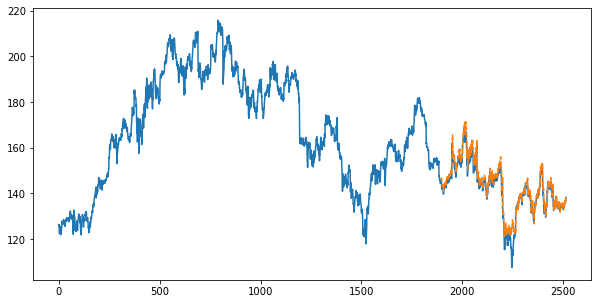

In [33]:
plt.figure(figsize=(10, 5))
plot_prediction(model_hybrid)